# Structure of the code
1. Primodial gas
2. Mass life time relation
3. Stellar yields tables
4. IMF
5. SNIa rate

# Algorithm of the code
1. Essential input

   (1) Star formation history

   (2) Stellar yields tables

   (3) Star formation efficiency

   (4) IMF

2. Initialize primorial gas `GasElement[0]`
3. Calculate the mass locked in zero-age main sequence `StarInitElement[0]` at `Age[0]`
4. Determine the ejecta `EjectElement[0]` of stellar population formed at `Age[0]` during `Age[i]` and `Age[i+1]` (i=0,1,...,N-1)

   (1) For AGB and SNcc, the ejecta is determined by $\mathrm{IMF}\times\mathrm{Yields}$

   (2) For SNIa, the ejecta is determined by the number of SNIa events and SNIa yields
   
5. `GasElement[1]=GasElement[0]+StarInitElement[0]-EjectElement[0]`
6. Likewise, update the rest `GasElement[i] = GasElement[i-1] + StarInitElement[i-1] - EjectElement[i-1]` (i=1,2,...,N-1)

# Some conventions
1. We consider the first 30 elements of the periodic table but the metallicity of the ejecta/wind is defined as $M_{\rm ini}-M_{\rm rem}-M_{\rm H}-M_{\rm He}$
2. The solar abundance tables in number are converted to in mass

   It refers to how much mass of each element per unit mass of hydrogen in the sun.
   The index of one item of `abund_tables` in the `constants.py` start from 1.
   For instance `abund_tables["Default"][2]` is how much mass of helium per unit mass of hydrogen in the `Default` table and 
   `abund_tables["Default"][0]` is set to 0.
3. Both the mass range of the IMF and the stellar yield tables is restricted to be $[0.08,150]~M_{\odot}$
   
   - If the minimum mass $M_{\rm min}$ of the IMF is larger than $0.08~M_{\odot}$, then the IMF in the range $[0.08,M_{\rm min}]~M_{\odot}$ is set to be zero.
   - As is often the case, the $M_{\rm min}$ in the stellar yield tables is larger than $0.08~M_{\odot}$, so the yield in the range $[0.08,M_{\rm min}]~M_{\odot}$ is set to be zero, and the $M_{\rm max}$ in the stellar yield tables is smaller than $150~M_{\odot}$, so the yield in the range $[M_{\rm max},150]~M_{\odot}$ is set to be the same as that at $M_{\rm max}$. As for the $M_{\rm rem}$, it is set to be $M_{\rm ini}$ in the range $[0.08,M_{\rm min}]~M_{\odot}$ and we keep $M_{\rm ini}-M_{\rm rem}$ a constant in the range $[M_{\rm max},150]~M_{\odot}$.
   - The number of sampled mass points in the stellar yield tables are often just a few, so we will interpolate the yield tables to get the yield at any mass in the range $[0.08,150]~M_{\odot}$.

4. About the star formation history file

   - You should input the star formation history in a txt file with just two columns, the first column is the time in `yr` and the second column is the star formation rate in $M_{\odot}~{\rm yr}^{-1}$.
   - You can add as many lines of comments as you want in the header of the txt file, but the comments should be started with `#`, which is the default comment symbol in `np.loadtxt`.
   - The star formation rate in the last line (the last time) won't be used in the calculation of the chemical evolution, so you should set it to be zero.

5. Units

   - The default unit of mass is $M_{\odot}$.
   - The default unit of time is `yr`.

# About the IMF
The IMF in `IMF` class defined in `utils.py` is NORMALIZED to be $\int_{0.08}^{150} \xi(m)dm=1$.
Assuming $M_{\ast, i}$ and $N_{\mathrm{formed}, i}$ are the formed mass and number of stars in ith epoch, respectively:
$$
N_{\mathrm{formed}, i} = \frac{M_{\ast, i}}{\int_{0.08}^{150} m \xi(m)dm}
$$

$N_{\mathrm{formed}, i}$ should be an integer, but we will NOT round it to the nearest integer.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 20, 2024
Last modified on May 27, 2024
@Author: Guan-Fu Liu

To calculate how the abundance evolves with time with variable IMF
To reproduce the Figure 10 in Nomoto et al. (2013).

Update: 
1. Separate utils.py into IMF.py, primordial_gas.py, SupernovaeIa.py, and MassLifetime.py
2. Interpolate the stellar yields of different initial metallicities.
3. Add stellar mass
4. Add SNcc events
5. Add AGB events
6. Add the abundances of the ejecta from SNcc
7. Add the abundances of the ejecta from AGB
8. Add the abundances of the ejecta from SNIa
"""
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, './')
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
import h5py
from tqdm import tqdm
import datetime
import re
# The following are the modules defined in the same directory
from MassLifetime import MassLifetime
from IMF import IMF
from SupernovaeIa import SNIa
import primordial_gas as pg
import constants
from InterpolateYields import InterpolateYields
%matplotlib widget

In [2]:
###### Set the input and output directories and essential parameters ######
input_dir = "./inputs"
output_dir = "./outputs"
SFE = 0.3 # Star formation efficiency
# 0.1 is a typical value, 0.3 is an enhanced value, larger than 0.5 is not physical
if SFE > 0.5:
    print("The star formation efficiency is too high, please check the input value.")
    print("The typical value is 0.1, the enhanced value is 0.3.")
    print("EXIT!")
    sys.exit()

IMF = IMF(IMF_type='Salpeter')
SNIa = SNIa(IMF.imf)
SNIaOn = True  # Whether to consider the SNIa
kind = 'linear-linear'
###### Set the input and output directories and essential parameters ######

###### Load the star formation history ######
SFH = { }
# SFH['File'] = f"{input_dir}/SFH-1delta.txt"
# SFH['Age'] = np.loadtxt(SFH['File'])[:, 0]
# SFH['SFR'] = np.loadtxt(SFH['File'])[:, 1]

SFH['File'] = f"{input_dir}/SFH.h5"
with h5py.File(SFH['File'], 'r') as f:
    SFH['Age'] = f['SFH/1Square'][...][:, 0]
    SFH['SFR'] = f['SFH/1Square'][...][:, 1]

SFH['Mstar'] = np.zeros(len(SFH['Age']))
SFH['TimeBin'] = np.zeros(len(SFH['Age']))
SFH['TimeBin'][:-1] = np.diff(SFH['Age'])  # The time bin of each time, the time bin of the last time is set to ZERO.
SFH['Mstar'][:-1] = SFH['SFR'][:-1] * np.diff(SFH['Age'])  # The mass of stars formed in each time bin
# We do not consider the mass of stars formed in the last time!
SFH['Mtot'] = np.sum(SFH['Mstar'])  # The total mass of stars formed.
if np.diff(SFH['Age'])[0] < 0:
    print("The age should be in ascending order!")
    print("EXIT!")
    sys.exit()
###### Load the star formation history ######

###### Load the yields table ######
yield_files = {
                "AGB+SNcc": "./inputs/NuPyCEE/agb_and_massive_stars_C15_N13_0_5_HNe/yields2.h5",
                # "AGB+SNcc": "./inputs/K10_N13_S16/agb_and_massive_stars_K10_N13/yields1.h5",
                "SNIa": "./inputs/NuPyCEE/sn1a_i99_W7/yields2.h5",
               }
files = {key: h5py.File(value, 'r') for key, value in yield_files.items()}
groups = {key: list(files[key].keys()) for key in yield_files.keys()}  # The available metallicity values in yield table
# The available metallicity values in yield table
if "Z_" in groups["AGB+SNcc"][0]:
    # for yields2.h5, the group names cannot contain "." and "_".
    # Therefore their group names are like "Z_0_0001", "Z_0_0003", etc.
    groups_Z = {key: [group.replace("Z_","Z=").replace("_",".") for group in groups[key]] for key in groups.keys()}
else:
    # for yields1.h5
    # Their group names are like "Z=0.0001", "Z=0.0003", etc.
    groups_Z = groups

Zyield = {key: np.array([float(group.split("=")[1]) for group in groups_Z[key]]) for key in groups.keys()}
ElemNotice = ["H", "He", "C", "N", "O", "Ca", "Ne", "Si", "Mg", "S", "Fe", "Other"] # The elements we are interested in
# It should contain H, He and Other.
# The finally selected elements are the intersection of ElemNotice and the elements avaliable in the yield table.
# You may as well not to notice too many elements, which will speed down the calculation.
if "H" not in ElemNotice:
    print("H should be in ElemNotice!")
    print("Add H to ElemNotice!")
    ElemNotice.append("H")
if "He" not in ElemNotice:
    print("He should be in ElemNotice!")
    print("Add He to ElemNotice!")
    ElemNotice.append("He")
if "Other" not in ElemNotice:
    print("Other should be in ElemNotice!")
    print("Add Other to ElemNotice!")
    ElemNotice.append("Other")
dfs = { }
ElemIntersect = { }
if "Z_" not in groups["AGB+SNcc"][0]:
    for key in files.keys():
        dfs[key] = { }
        ElemIntersect[key] = { }
        for group in groups[key]:
            if key == "SNIa":
                dfs[key][group] = pd.DataFrame(files[key][group]['Original'][...])
            else:
                dfs[key][group] = pd.DataFrame(files[key][group]['Interpolated'][...])
            dfs[key][group].loc[:, 'M'] = dfs[key][group].loc[:, 'M'].astype(str)
            dfs[key][group].set_index('M', inplace=True)
            index = dfs[key][group].index
            index = [False if a in ElemNotice + ['Mrem'] else True for a in index]
            # Add the mass of the elements not in ElemNotice to the "Other" element
            if "Other" in dfs[key][group].index:
                dfs[key][group].loc["Other"] += dfs[key][group].loc[index].sum(axis=0)
            else:
                dfs[key][group].loc["Other"] = dfs[key][group].loc[index].sum(axis=0)
            ElemIntersect[key][group] = list(set(ElemNotice).intersection(set(dfs[key][group].index)))
else:
    for key in files.keys():
        dfs[key] = { }
        ElemIntersect[key] = { }
        for group in groups[key]:
            if key == "SNIa":
                dfs[key][group] = pd.read_hdf(yield_files["SNIa"], key="%s/Original"%group)
            else:
                dfs[key][group] = pd.read_hdf(yield_files["AGB+SNcc"], key="%s/Interpolated"%group)
            index = dfs[key][group].index
            index = [False if a in ElemNotice + ['Mrem'] else True for a in index]
            # Add the mass of the elements not in ElemNotice to the "Other" element
            if "Other" in dfs[key][group].index:
                dfs[key][group].loc["Other"] += dfs[key][group].loc[index].sum(axis=0)
            else:
                dfs[key][group].loc["Other"] = dfs[key][group].loc[index].sum(axis=0)
            ElemIntersect[key][group] = list(set(ElemNotice).intersection(set(dfs[key][group].index)))

for key in files.keys():
    for group in groups[key]:
        if len(set(ElemNotice)-set(ElemIntersect[key][group]))>0:
            print("The elements you notice but not available in the yield table of %s, %s are\n" %\
                 (key, group), set(ElemNotice)-set(ElemIntersect[key][group]))


# If one element is only available in part of the metallicity values, you should not notice it.
# For example, if "C" is only available in Z=0.001 of AGB+SNcc table, 
# you should not notice "C", namely, you should not include "C" in ElemNotice.
# The yields of "C" should be added to "Other".
# It is the same for SNIa table.
# It is OK if one element is just available in AGB+SNcc table but not in SNIa table,
# which is the case for "H" and "He".

# The following code is to check if you notice some elements that are just available in part of AGB+SNcc yield table 
# or SNIa yield table.

Elems = {key: [value for value in ElemIntersect[key].values()] for key in files.keys()}
flag = False
for key in files.keys():
    n = len(list(set.intersection(*map(set, Elems[key]))))
    for group in groups[key]:
        if len(ElemIntersect[key][group]) != n:
            flag = True
            print("Warning: the elements not available in the yield table of %s, %s are" %\
                 (key, group), set(ElemIntersect[key][group])-set.intersection(*map(set, Elems[key])))
            print("Although they are available in the %s yield table of the other metallicities,"%key)
            print("they should be and will be removed from the ElemNotice.")
        
            for elem in list(set(ElemIntersect[key][group])-set.intersection(*map(set, Elems[key]))):
                ElemNotice.remove(elem)

# Re-generate the dfs and ElemIntersect
if flag and "Z_" not in groups["AGB+SNcc"][0]:
    dfs = { }
    ElemIntersect = { }
    for key in files.keys():
        dfs[key] = { }
        ElemIntersect[key] = { }
        for group in groups[key]:
            if key == "SNIa":
                dfs[key][group] = pd.DataFrame(files[key][group]['Original'][...])
            else:
                dfs[key][group] = pd.DataFrame(files[key][group]['Interpolated'][...])
            dfs[key][group].loc[:, 'M'] = dfs[key][group].loc[:, 'M'].astype(str)
            dfs[key][group].set_index('M', inplace=True)
            index = dfs[key][group].index
            index = [False if a in ElemNotice + ['Mrem'] else True for a in index]
            # Add the mass of the elements not in ElemNotice to the "Other" element
            if "Other" in dfs[key][group].index:
                dfs[key][group].loc["Other"] += dfs[key][group].loc[index].sum(axis=0)
            else:
                dfs[key][group].loc["Other"] = dfs[key][group].loc[index].sum(axis=0)
            ElemIntersect[key][group] = list(set(ElemNotice).intersection(set(dfs[key][group].index)))

    for key in files.keys():
        for group in groups[key]:
            if len(set(ElemNotice)-set(ElemIntersect[key][group]))>0:
                print("The elements you notice but not available in the yield table of %s, %s are\n" %\
                    (key, group), set(ElemNotice)-set(ElemIntersect[key][group]))

if flag and "Z_" in groups["AGB+SNcc"][0]:
    dfs = { }
    ElemIntersect = { }
    for key in files.keys():
        dfs[key] = { }
        ElemIntersect[key] = { }
        for group in groups[key]:
            if key == "SNIa":
                dfs[key][group] = pd.read_hdf(yield_files["SNIa"], key="%s/Original"%group)
            else:
                dfs[key][group] = pd.read_hdf(yield_files["AGB+SNcc"], key="%s/Interpolated"%group)
            index = dfs[key][group].index
            index = [False if a in ElemNotice + ['Mrem'] else True for a in index]
            # Add the mass of the elements not in ElemNotice to the "Other" element
            if "Other" in dfs[key][group].index:
                dfs[key][group].loc["Other"] += dfs[key][group].loc[index].sum(axis=0)
            else:
                dfs[key][group].loc["Other"] = dfs[key][group].loc[index].sum(axis=0)
            ElemIntersect[key][group] = list(set(ElemNotice).intersection(set(dfs[key][group].index)))

    for key in files.keys():
        for group in groups[key]:
            if len(set(ElemNotice)-set(ElemIntersect[key][group]))>0:
                print("The elements you notice but not available in the yield table of %s, %s are\n" %\
                    (key, group), set(ElemNotice)-set(ElemIntersect[key][group]))

###### Load the yields table ######

The elements you notice but not available in the yield table of SNIa, Z_0_02 are
 {'H', 'He'}


In [3]:
###### Read the mass lifetime relation ######
mass_lifetime_file = "./inputs/NuPyCEE/agb_and_massive_stars_C15_N13_0_5_HNe/yields2.h5"
file = h5py.File(mass_lifetime_file, "r")
lifetime = { }
for key in file.keys():
    key1 = key.replace("Z_","Z=").replace("_",".")  # in case it is Z_0_0001, as is the case for yields2.h5
    lifetime[key1] = { }
    lifetime[key1]['Mini'] = file[key]['MassLifetime'][:,0].astype(float)
    lifetime[key1]['lifetime'] = file[key]['MassLifetime'][:,1].astype(float)

mass_lifetime = MassLifetime(lifetime=lifetime)
file.close()
###### Read the mass lifetime relation ######

In [4]:
###### Determine the primordial gas ######
mass = SFH['Mtot'] / SFE  # The total mass of the primordial gas in the unit of Msun
solar_set = "Default"  # The solar abundance set
pr_gas = pg.Primordial_gas(mass=mass, Z_0=0).add_metals(abund_table=constants.abund_tables[solar_set])
###### Determine the primordial gas ######

###### Initialize other essential variables ######
YieldsTable = np.empty((len(SFH['Age']), 2), dtype=object)
GasElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
ZGas = np.zeros(len(SFH['Age']), dtype=np.float64)
Nstar = np.zeros(len(SFH['Age']), dtype=np.float64)
StarInitElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
EjectElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
SNIaElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
SNccElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
AGB_Element = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
SNIaNum = np.zeros(len(SFH['Age']), dtype=np.float64)
SNccNum = np.zeros(len(SFH['Age']), dtype=np.float64)
AGB_Num = np.zeros(len(SFH['Age']), dtype=np.float64)
interp_Y = InterpolateYields(dfs, kind=kind)
###### Initialize other essential variables ######

###### Step 0: Initialize the first age, the primordial gas ######
# The definition of the following variables is can be found in the excel file Variables.xlsx
GasElement[0] = pr_gas['Gas']
ZGas[0] = GasElement[0, 3:].sum() / GasElement.sum()  # The metallicity of the primordial gas
StarInitElement[0] = SFH['Mstar'][0] * (GasElement[0]/GasElement[0].sum())
Nstar[0] = SFH['Mstar'][0] / quad(lambda m: m*IMF.imf(m), constants.Mstar_min, constants.Mstar_max, full_output=1)[0]
StellarMass = SFH['Mstar'].cumsum()
print("Step 0: Initialize the first time, the primordial gas")
dEjectElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
dSNIaElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
dSNccElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
dAGB_Element = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
dSNIaNum = np.zeros(len(SFH['Age']), dtype=np.float64)
dSNccNum = np.zeros(len(SFH['Age']), dtype=np.float64)
dAGB_Num = np.zeros(len(SFH['Age']), dtype=np.float64)
# mass boundary of each time bin
dStellarMass = np.zeros(len(SFH['Age']), dtype=np.float64)
mass_bounds = np.array([constants.Mstar_max]+
                            [mass_lifetime.lifetime_to_mass(SFH['TimeBin'][0:k+1].sum(), ZGas[0]) \
                             for k in range(0, len(SFH['Age'])-1)])
for j in tqdm(range(0, len(SFH['Age'])-1)):
    # Calculate the mass of ejceta from AGB and SNcc happened in this time bin,
    # whose progenitor stars formed at Age[0].
    for elem in ElemIntersect["AGB+SNcc"][groups["AGB+SNcc"][0]]:
        ElemIndex = constants.elem_names.index(elem)
        interp = interp_Y.interps['AGB+SNcc'](ZGas[0], elem)
        dEjectElement[j, ElemIndex] = Nstar[0]*(quad(lambda m:
                                        IMF.imf(m)*interp(m),
                                        mass_bounds[j+1], mass_bounds[j],
                                        epsrel=1e-5, limit=80, full_output=1)[0])
        
        ###### interp = interp_Y.interps['AGB+SNcc'](ZGas[0], elem) is a MUST! ######
        # You SHOULD NOT use the following code:
        # dEjectElement[j, ElemIndex] = Nstar[0]*(quad(lambda m:
        #                                 IMF.imf(m)*interp_Y.interps['AGB+SNcc'](ZGas[0], elem)(m),
        #                                 mass_bounds[j+1], mass_bounds[j],
        #                                 epsrel=1e-5, limit=80, full_output=1)[0])
        # It will slow down the calculation.
        # quad will call the interp_Y.interps['AGB+SNcc'](ZGas[0], elem) again and again, which is not necessary
        # and slow down the calculation.
        ###### interp = interp_Y.interps['AGB+SNcc'](ZGas[0], elem) is a MUST! ######

    # Calculate the mass of ejecta from SNcc and the number of SNcc events happened in this time bin,
    # whose progenitor stars formed at Age[0].
    # Both mass_bounds[j+1] and mass_bounds[j] could be in three ranges:
    # >constants.SNcc_max, < constants.SNcc_max, [constants.SNcc_min, constants.SNcc_max]
    # 3*3=9 cases.
    # Actually there are only 6 cases because mass_bounds[j+1] < mass_bounds[j].
    # However, it is still complicated.
    # Here, I provide a simple way to calculate the mass of ejecta from SNcc and the number of SNcc events happened in this time bin.
    # 1. Calculate max(constants.SNcc_min, mass_bounds[j+1]) and min(constants.SNcc_max, mass_bounds[j])
    # 2. If max(constants.SNcc_min, mass_bounds[j+1])>=min(constants.SNcc_max, mass_bounds[j]), no ejecta come from SNcc.
    # 3. If max(constants.SNcc_min, mass_bounds[j+1])<min(constants.SNcc_max, mass_bounds[j]), all ejecta of SNcc come from the 
    #    mass range [max(constants.SNcc_min, mass_bounds[j+1]), min(constants.SNcc_max, mass_bounds[j])].
    SNcc_low = np.maximum(constants.SNcc_min, mass_bounds[j+1])
    SNcc_high = np.minimum(constants.SNcc_max, mass_bounds[j])
    if SNcc_high > SNcc_low:
        dSNccNum[j] = Nstar[0]*(quad(lambda m: IMF.imf(m), SNcc_low, SNcc_high,
                                     epsrel=1e-5, limit=80, full_output=1)[0])
        for elem in ElemIntersect["AGB+SNcc"][groups["AGB+SNcc"][0]]:
            interp = interp_Y.interps['AGB+SNcc'](ZGas[0], elem)
            ElemIndex = constants.elem_names.index(elem)
            dSNccElement[j, ElemIndex] = Nstar[0]*(quad(lambda m:
                                        IMF.imf(m)*interp(m),
                                        SNcc_low, SNcc_high,
                                        epsrel=1e-5, limit=80, full_output=1)[0])
    else:
        pass
    # Calculate the mass of "ejecta" from AGB stars and the number of AGB events happened in this time bin,
    # whose progenitor stars formed at Age[0].
    # Again, both mass_bounds[j+1] and mass_bounds[j] could be in three ranges, ...
    # We adopt the same strategy as we did for SNcc.
    AGB_low = np.maximum(constants.AGB_min, mass_bounds[j+1])
    AGB_high = np.minimum(constants.AGB_max, mass_bounds[j])
    if AGB_high > AGB_low:
        dAGB_Num[j] = Nstar[0]*(quad(lambda m: IMF.imf(m), AGB_low, AGB_high,
                                    epsrel=1e-5, limit=80, full_output=1)[0])
        for elem in ElemIntersect["AGB+SNcc"][groups["AGB+SNcc"][0]]:
            interp = interp_Y.interps['AGB+SNcc'](ZGas[0], elem)
            ElemIndex = constants.elem_names.index(elem)
            dAGB_Element[j, ElemIndex] = Nstar[0]*(quad(lambda m:
                                        IMF.imf(m)*interp(m),
                                        AGB_low, AGB_high,
                                        epsrel=1e-5, limit=80, full_output=1)[0])
    else:
        pass
    # Calculate the mass of stars that explode or evolved as AGB stars in this time bin,
    # whose progenitor stars formed at Age[0].
    dStellarMass[j+1] = Nstar[0]*(quad(lambda m: m*IMF.imf(m), mass_bounds[j+1], mass_bounds[j],
                                        epsrel=1e-5, limit=80, full_output=1)[0])
    dSNIaNum[j] = SNIa.number(SFH['Mstar'][0], SFH['Age'][j]-SFH['Age'][0], SFH['Age'][j+1]-SFH['Age'][0])

StellarMass -= dStellarMass.cumsum()
# The ejected mass of elements from AGB and SNcc, whose progenitor stars formed at Age[0]
EjectElement += dEjectElement
# The ejected mass of elements from SNcc, whose progenitor stars formed at Age[0]
SNccElement += dSNccElement
# The ejected mass of elements from AGB, whose progenitor stars formed at Age[0]
AGB_Element += dAGB_Element
Zindex = interp_Y.Zindex
if SNIaOn:
    # Calculate the number of SNIa events happened in this time bin, progenitor stars formed at Age[0]
    for elem in ElemIntersect["SNIa"][groups["SNIa"][0]]:
        y = interp_Y.interps['SNIa'](ZGas[0], elem)
        ElemIndex = constants.elem_names.index(elem)
        dSNIaElement[:, ElemIndex] += dSNIaNum * y
    SNIaNum += dSNIaNum
    dEjectElement += dSNIaElement
    EjectElement += dSNIaElement
    SNIaElement += dSNIaElement
    YieldsTable[0,0] = "AGB+SNcc: %s, SNIa: %s" % (groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']],
                                                groups["SNIa"][Zindex["SNIa"]['low']])
    YieldsTable[0,1] = "AGB+SNcc: %s, SNIa: %s" % (groups["AGB+SNcc"][Zindex["AGB+SNcc"]['high']],
                                                groups["SNIa"][Zindex["SNIa"]['high']])
else:
    pass
    YieldsTable[0,0] = "AGB+SNcc: %s" % groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']]
    YieldsTable[0,1] = "AGB+SNcc: %s" % groups["AGB+SNcc"][Zindex["AGB+SNcc"]['high']]
###### Step 0: Initialize the first age, the primordial gas ######

Step 0: Initialize the first time, the primordial gas


100%|██████████| 1363/1363 [00:08<00:00, 169.40it/s]


In [5]:
###### Step 1: Calculate the remaining ages ######
print("Step 1: Calculate the remaining ages")
for i in tqdm(range(1, len(SFH['Age'])-1)):
    GasElement[i] = GasElement[i-1] + EjectElement[i-1] - StarInitElement[i-1]
    ZGas[i] = GasElement[i, 3:].sum() / GasElement[i].sum()
    dEjectElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
    dEjectElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
    dSNIaElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
    dSNccElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
    dAGB_Element = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
    dSNIaNum = np.zeros(len(SFH['Age']), dtype=np.float64)
    dSNccNum = np.zeros(len(SFH['Age']), dtype=np.float64)
    dAGB_Num = np.zeros(len(SFH['Age']), dtype=np.float64)
    dStellarMass = np.zeros(len(SFH['Age']), dtype=np.float64)
    if SFH['Mstar'][i] > 0:
        StarInitElement[i] = SFH['Mstar'][i] * (GasElement[i]/GasElement[i].sum())
        Nstar[i] = SFH['Mstar'][i] / quad(lambda m: m*IMF.imf(m), constants.Mstar_min, constants.Mstar_max, full_output=1)[0]
        mass_bounds = np.array([constants.Mstar_max]+
                                [mass_lifetime.lifetime_to_mass(SFH['TimeBin'][i:k+1].sum(), ZGas[i])\
                                    for k in range(i, len(SFH['Age'])-1)])
        # If the star formation rate at Age[i] is non-zero, 
        # the stars formed at Age[i] will explode and enrich the gas in the following ages.
        for j in range(i, len(SFH['Age'])-1):
            # Calculate the mass of ejceta from AGB and SNcc happened in this time bin
            for elem in ElemIntersect["AGB+SNcc"][groups["AGB+SNcc"][0]]:
                # Interpolate the stellar yields of different initial metallicities
                interp = interp_Y.interps['AGB+SNcc'](ZGas[i], elem)
                ElemIndex = constants.elem_names.index(elem)
                dEjectElement[j, ElemIndex] = Nstar[i]*(quad(lambda m:
                                                IMF.imf(m)*interp(m),
                                                mass_bounds[j+1-i], mass_bounds[j-i],
                                                epsrel=1e-5, limit=80, full_output=1)[0])
            # Calculate the mass of ejecta from SNcc and the number of SNcc events happened in this time bin,
            # whose progenitor stars formed at Age[i].
            SNcc_low = np.maximum(constants.SNcc_min, mass_bounds[j+1-i])
            SNcc_high = np.minimum(constants.SNcc_max, mass_bounds[j-i])
            if SNcc_high > SNcc_low:
                dSNccNum[j] = Nstar[i]*(quad(lambda m: IMF.imf(m), SNcc_low, SNcc_high,
                                            epsrel=1e-5, limit=80, full_output=1)[0])
                for elem in ElemIntersect["AGB+SNcc"][groups["AGB+SNcc"][0]]:
                    interp = interp_Y.interps['AGB+SNcc'](ZGas[i], elem)
                    ElemIndex = constants.elem_names.index(elem)
                    dSNccElement[j, ElemIndex] = Nstar[i]*(quad(lambda m:
                                                IMF.imf(m)*interp(m),
                                                SNcc_low, SNcc_high,
                                                epsrel=1e-5, limit=80, full_output=1)[0])
            else:
                pass
            # Calculate the mass of "ejecta" from AGB stars and the number of AGB events happened in this time bin,
            # whose progenitor stars formed at Age[i].
            AGB_low = np.maximum(constants.AGB_min, mass_bounds[j+1-i])
            AGB_high = np.minimum(constants.AGB_max, mass_bounds[j-i])
            if AGB_high > AGB_low:
                dAGB_Num[j] = Nstar[i]*(quad(lambda m: IMF.imf(m), AGB_low, AGB_high,
                                            epsrel=1e-5, limit=80, full_output=1)[0])
                for elem in ElemIntersect["AGB+SNcc"][groups["AGB+SNcc"][0]]:
                    interp = interp_Y.interps['AGB+SNcc'](ZGas[i], elem)
                    ElemIndex = constants.elem_names.index(elem)
                    dAGB_Element[j, ElemIndex] = Nstar[i]*(quad(lambda m:
                                                IMF.imf(m)*interp(m),
                                                AGB_low, AGB_high,
                                                epsrel=1e-5, limit=80, full_output=1)[0])
            else:
                pass
            # Calculate the mass of stars that explode or evolved as AGB stars in this time bin,
            # whose progenitor stars formed at Age[i].
            dStellarMass[j+1] = Nstar[i]*(quad(lambda m: m*IMF.imf(m), mass_bounds[j+1-i], mass_bounds[j-i],
                                                epsrel=1e-5, limit=80, full_output=1)[0])
            dSNIaNum[j] = SNIa.number(SFH['Mstar'][i], SFH['Age'][j]-SFH['Age'][i], SFH['Age'][j+1]-SFH['Age'][i])
        
        StellarMass -= dStellarMass.cumsum()
        # The ejected mass of elements from AGB and SNcc, whose progenitor stars formed at Age[i].
        EjectElement += dEjectElement
        # The ejected mass of elements from SNcc, whose progenitor stars formed at Age[i].
        SNccElement += dSNccElement
        # The ejected mass of elements
        AGB_Element += dAGB_Element
        Zindex = interp_Y.Zindex
        if SNIaOn:
            # Calculate the number of SNIa events happened in this time bin, progenitor stars formed at Age[i]
            for elem in ElemIntersect["SNIa"][groups["SNIa"][0]]:
                ElemIndex = constants.elem_names.index(elem)
                y = interp_Y.interps['SNIa'](ZGas[i], elem)
                dSNIaElement[:, ElemIndex] += dSNIaNum * y
            SNIaNum += dSNIaNum
            dEjectElement += dSNIaElement
            EjectElement += dSNIaElement
            SNIaElement += dSNIaElement
            YieldsTable[i,0] = "AGB+SNcc: %s, SNIa: %s" % (groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']],
                                                    groups["SNIa"][Zindex["SNIa"]['low']])
            YieldsTable[i,1] = "AGB+SNcc: %s, SNIa: %s" % (groups["AGB+SNcc"][Zindex["AGB+SNcc"]['high']],
                                                    groups["SNIa"][Zindex["SNIa"]['high']])
        else:
            YieldsTable[i,0] = "AGB+SNcc: %s" % groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']]
            YieldsTable[i,1] = "AGB+SNcc: %s" % groups["AGB+SNcc"][Zindex["AGB+SNcc"]['high']]

    else:
        # If no star formation between this age and the next age, 
        # there is no ejecta from the stars formed in this time interval.
        YieldsTable[i,0] = "No Star Formation"
        YieldsTable[i,1] = "No Star Formation"
        continue


# The last age
GasElement[len(SFH['Age'])-1] = GasElement[len(SFH['Age'])-2] + \
    EjectElement[len(SFH['Age'])-2] - StarInitElement[len(SFH['Age'])-2]
ZGas[len(SFH['Age'])-1] = GasElement[len(SFH['Age'])-1, 3:].sum() / GasElement[len(SFH['Age'])-1].sum()
YieldsTable[len(SFH['Age'])-1,0] = "No Star Formation"
YieldsTable[len(SFH['Age'])-1,1] = "No Star Formation"
###### Step 1: Calculate the remaining ages ######

for file in files.values():
    file.close()

Step 1: Calculate the remaining ages


100%|██████████| 1362/1362 [24:42<00:00,  1.09s/it]


# Add the IMF information in the output file!!!!

In [6]:
####### Step 2: Save the results #######
# Get the current date and time
current_time = datetime.datetime.now()
# Format the date and time as "YYYY-MM-DD-HH-MM"
formatted_time = current_time.strftime('%Y-%m-%d-%H-%M')
with h5py.File(f"{output_dir}/%s-4.h5"%formatted_time, 'w') as f:

    f.attrs["AGB+SNcc yield file"] = yield_files["AGB+SNcc"]
    f.attrs["SNIa yield file"] = yield_files["SNIa"]
    f.attrs["SFH file"] = SFH['File']
    f.attrs['Concerned Elements'] = ElemNotice
    if SNIaOn:
        f.attrs["SNIaOn"] = "Yes"
    else:
        f.attrs["SNIaOn"] = "No"
    f.create_group("Star")
    f["Star"].attrs["Comments"] = "Mass in Msun, Time in Gyr, SFR in Msun/yr, Mtot in Msun"
    f["Star"].attrs["SFE"] = SFE
    f["Star"].attrs["Mtot"] = SFH["Mtot"]
    f.create_dataset("Star/StarInitElement", data=StarInitElement)
    f.create_dataset("Star/SNIaNum", data=SNIaNum)
    f.create_dataset("Star/SNccNum", data=SNccNum)
    f.create_dataset("Star/AGB_Num", data=AGB_Num)
    f.create_dataset("Star/Age", data=SFH['Age'])
    f.create_dataset("Star/SFR", data=SFH['SFR'])
    f.create_dataset("Star/Mstar", data=SFH['Mstar'])
    f.create_dataset("Star/TimeBin", data=SFH['TimeBin'])
    f.create_dataset("Star/Nstar", data=Nstar)
    f.create_dataset("Star/StellarMass", data=StellarMass)

    f.create_group("Gas")
    f.create_dataset("Gas/GasElement", data=GasElement)
    f.create_dataset("Gas/ZGas", data=ZGas)
    f.create_dataset("Gas/EjectElement", data=EjectElement)
    f.create_dataset("Gas/SNIaElement", data=SNIaElement)
    f.create_dataset("Gas/SNccElement", data=SNccElement)
    f.create_dataset("Gas/AGB_Element", data=AGB_Element)
    f.create_dataset("Gas/YieldsTable", data=np.array(YieldsTable, dtype='S'))

####### Step 2: Save the results #######
print(formatted_time, SNIaOn)

2024-05-27-20-27 True


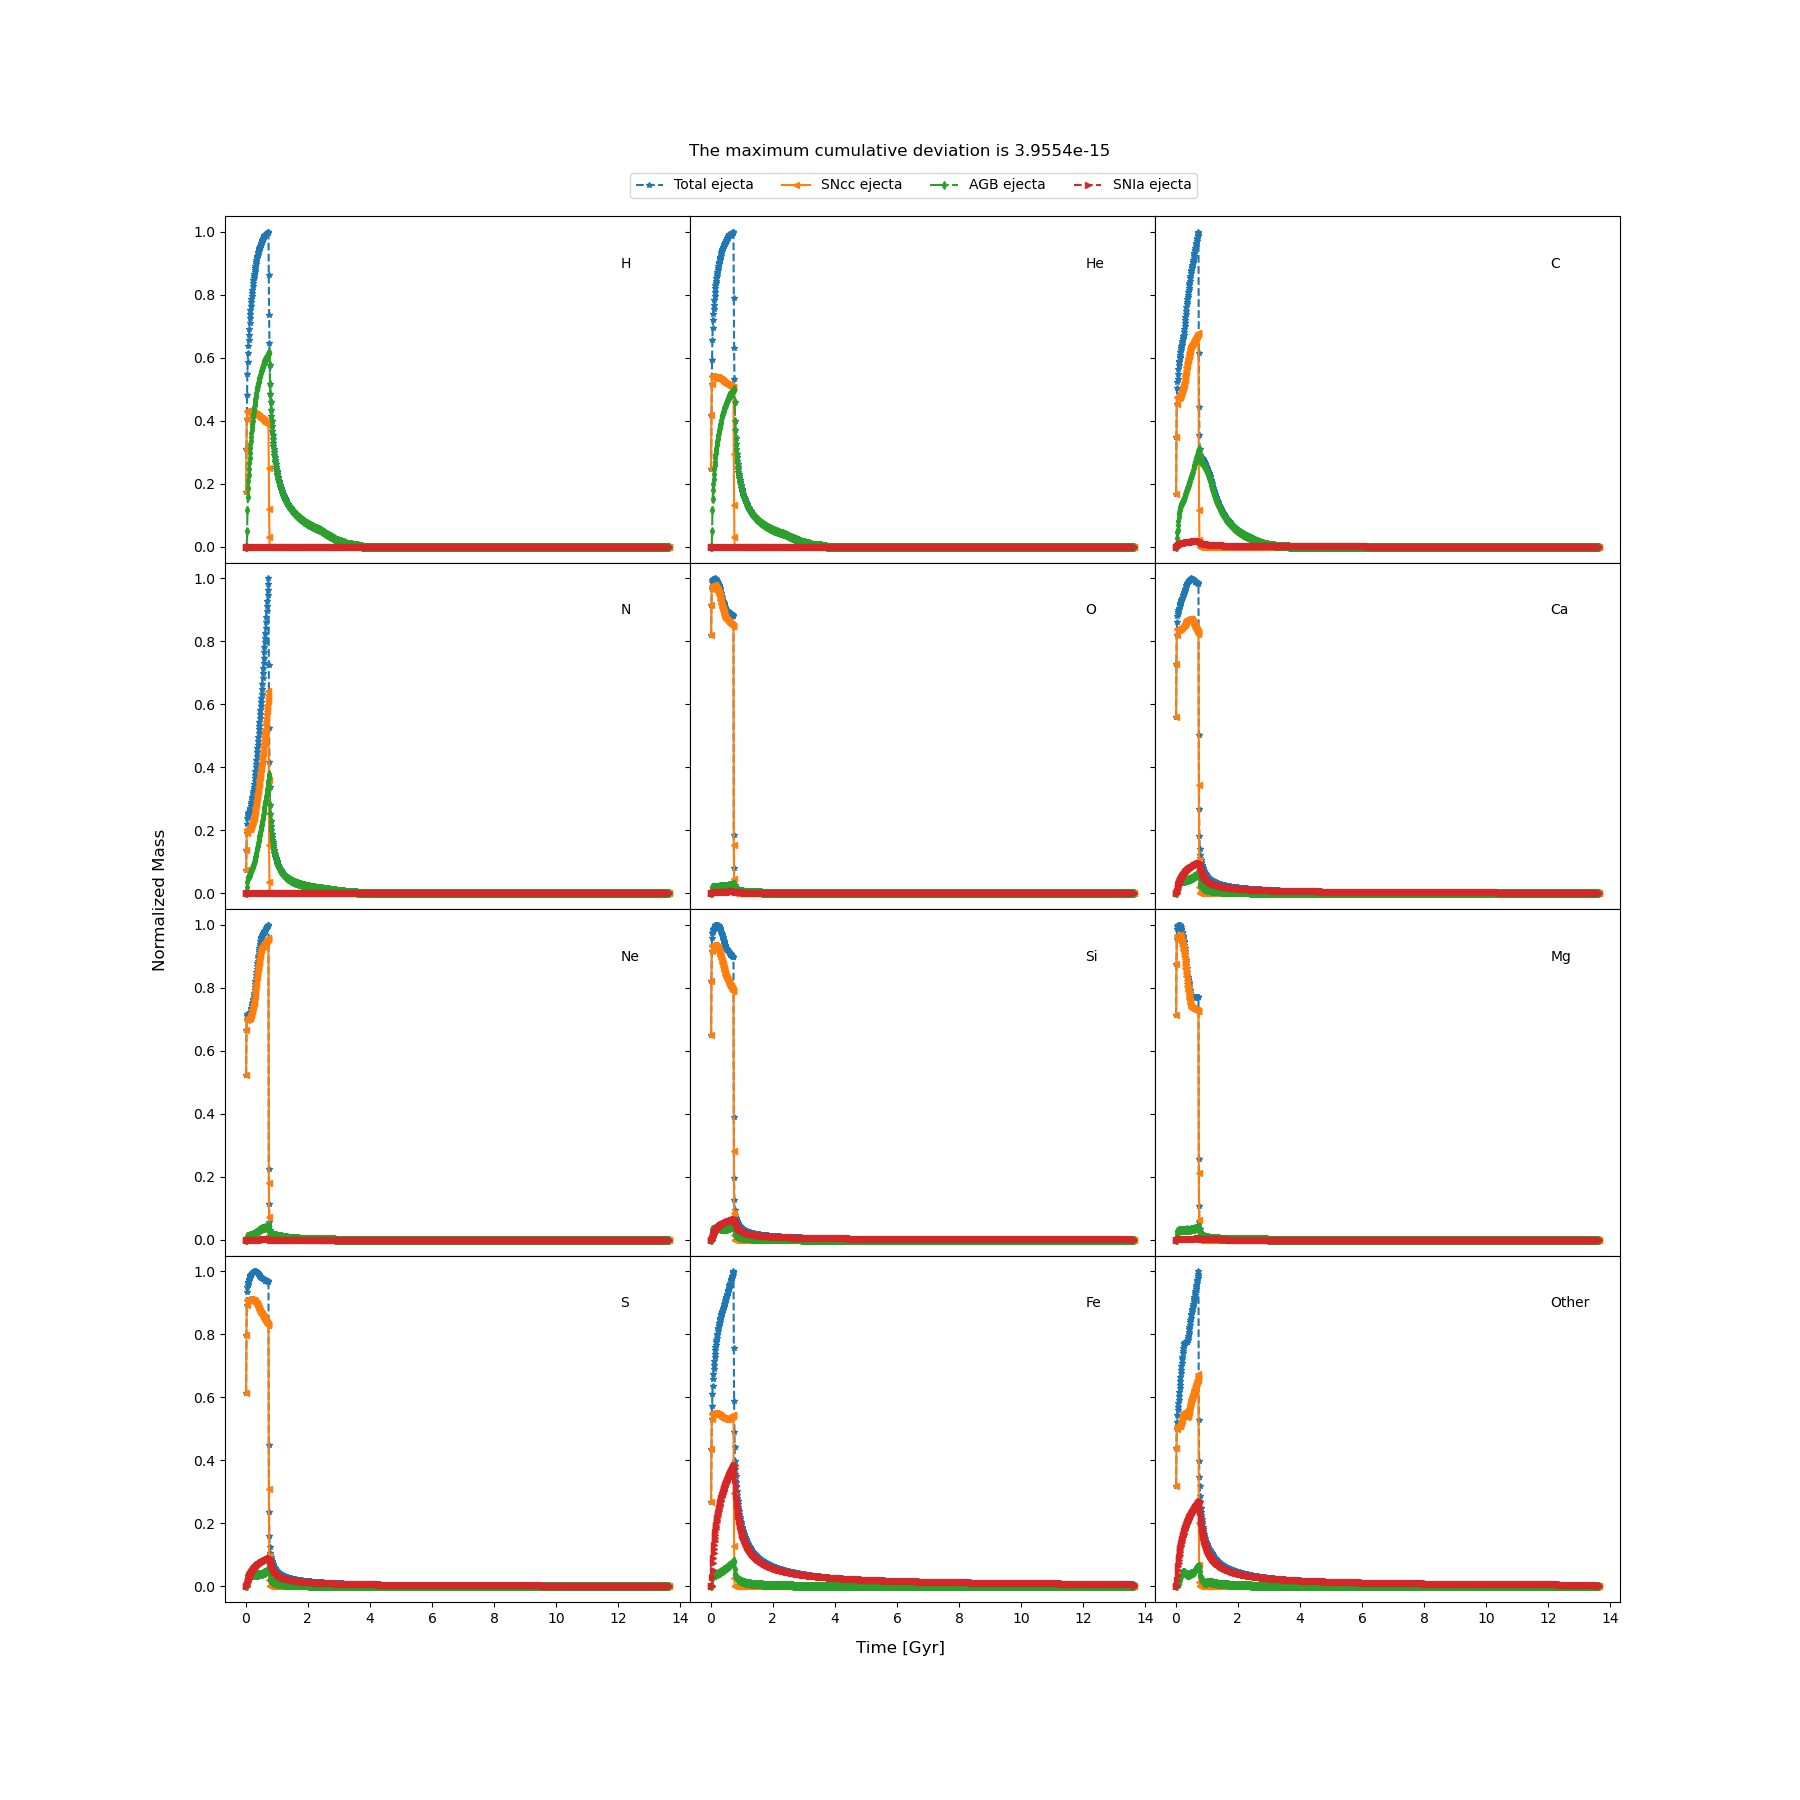

8.940696716308594e-08


In [7]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
axes = { }
for i, elem in enumerate(ElemNotice):
    axes[elem] = fig.add_subplot(gs[i//3, i%3])
    norm = EjectElement[:, constants.elem_names.index(elem)].max()
    line1, = axes[elem].plot(SFH['Age']/1e9, EjectElement[:, constants.elem_names.index(elem)]/norm,
                              '--*', markersize=4, label="Total ejecta")
    line2, = axes[elem].plot(SFH['Age']/1e9, SNccElement[:, constants.elem_names.index(elem)]/norm,
                              '-<', markersize=4, label="SNcc ejecta")
    line3, = axes[elem].plot(SFH['Age']/1e9, AGB_Element[:, constants.elem_names.index(elem)]/norm,
                              '-.d', markersize=4, label="AGB ejecta")
    line4, = axes[elem].plot(SFH['Age']/1e9, SNIaElement[:, constants.elem_names.index(elem)]/norm,
                              '-->', markersize=4, label="SNIa ejecta")
    if i not in [9, 10, 11]:
        axes[elem].set_xticklabels([])
    if i not in [0, 3, 6, 9]:
        axes[elem].set_yticklabels([])
    axes[elem].annotate(elem, xy=(0.85, 0.85), xycoords='axes fraction')

fig.supxlabel("Time [Gyr]", y=0.08)
fig.supylabel(r"Normalized Mass", x=0.085)
fig.legend((line1, line2, line3, line4), ("Total ejecta", "SNcc ejecta", "AGB ejecta", "SNIa ejecta"), loc=(0.35, 0.89), ncol=4)
deviation = np.abs(EjectElement.cumsum(axis=0)-SNccElement.cumsum(axis=0)-AGB_Element.cumsum(axis=0)-SNIaElement.cumsum(axis=0))
mask = EjectElement>0
deviation = deviation[mask]
deviation = deviation / EjectElement.cumsum(axis=0)[mask]
deviation = deviation.max()
fig.suptitle("The maximum cumulative deviation is %0.4e" % deviation, y=0.92)
fig.savefig("Ejecta-all.pdf", dpi=300)
plt.show()
print(np.abs(EjectElement-SNccElement-AGB_Element-SNIaElement).max())

In [8]:
plt.close("all")

No such comm: b1578b0ae97144d3860d94e5b5330f0d
No such comm: b1578b0ae97144d3860d94e5b5330f0d
No such comm: b1578b0ae97144d3860d94e5b5330f0d
No such comm: b1578b0ae97144d3860d94e5b5330f0d


In [9]:
EjectElement.cumsum(axis=0).shape
# -SNccElement-AGB_Element-SNIaElement

(1364, 32)

In [10]:
EjectElement.cumsum(axis=0)[:, 1]

array([6.58821975e+07, 1.83770714e+08, 3.37381969e+08, ...,
       3.44409795e+10, 3.44409795e+10, 3.44409795e+10])

In [11]:
EjectElement[:, 1]

array([6.58821975e+07, 1.17888517e+08, 1.53611255e+08, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [12]:
np.abs(GasElement[1:] - (GasElement[0]+EjectElement[:-1].cumsum(axis=0)-StarInitElement[:-1].cumsum(axis=0))).max()

0.00048828125

In [13]:
GasElement[1:].max(), 1e-15

(547491410018.579, 1e-15)

In [14]:
np.unravel_index(GasElement.argmax(), GasElement.shape)

(0, 1)

# Simple plot to check

In [15]:
def GetZi2Zj(GasElement, Zi, Zj, solar_set, fill_value=None):
    """
    To get the ratio of the element j to the element i in the solar unit.

    If the mass of the element j at some ages are zero, the ratio of the element j to the element i is set to fill_value.

    Parameters
    ----------
    GasElement : numpy array
        The mass of elements. The shape of GasElement should be (N, 32). Here N is them number of ages, 32 is the number of elements
        (the first and the last elemen are empty and "others", should not be used).
    Zi : str
        The element i. It should be in the list of constants.elem_names, namely, from H to Zn (Z=1, 2, 3, ..., 30).
    Zj : str
        The element j. It should be in the list of constants.elem_names, namely, from H to Zn (Z=1, 2, 3, ..., 30).
    solar_set : str
        The solar abundance set. It should be in the list of constants.abund_tables.keys().
    fill_value : float or None, optional
        The value to fill the ratio of the element j to the element i if the mass of the element j or the element i is zero.
        If it is None, mask the ages where the mass of the element j is zero, which will change the shape of the output.
        If it is a float, it should be a positive number.

    Returns
    -------
    Zi2Zj: dict
        The ratio of the element j to the element i in the solar unit.
        Zi2Zj['%s/%s'%(Zi, Zj)] is the ratio of the element j to the element i, in the solar unit.
        Zi2Zj['[%s/%s]'%(Zi, Zj)] is log10(Zi2Zj['%s/%s'%(Zi, Zj)]).
        Zi2Zj['%s/%s-mask'%(Zi,Zj)] is the mask of the ages where BOTH of the mass of the element j and i is POSITIVE.
    """
    if Zi not in constants.elem_names or Zj not in constants.elem_names:
        print("The element should be in the list of constants.elem_names, which is ", constants.elem_names)
        return None
    if solar_set not in constants.abund_tables.keys():
        print("The solar abundance set should be in the list of constants.abund_tables.keys(), which is ",
               constants.abund_tables.keys())
        return None
    Zi2Zj_solar = constants.abund_tables[solar_set][constants.elem_names.index(Zi)] / \
                   constants.abund_tables[solar_set][constants.elem_names.index(Zj)]
    mask = GasElement[:, constants.elem_names.index(Zj)] > 0
    mask = mask & (GasElement[:, constants.elem_names.index(Zi)] > 0)
    Zi2Zj = { }
    if fill_value is None:
        Zi2Zj['%s/%s'%(Zi, Zj)] = GasElement[mask, constants.elem_names.index(Zi)] / \
                                  GasElement[mask, constants.elem_names.index(Zj)] / Zi2Zj_solar
        Zi2Zj['[%s/%s]'%(Zi, Zj)] = np.log10(Zi2Zj['%s/%s'%(Zi, Zj)])
    else:
        Zi2Zj['%s/%s'%(Zi, Zj)] = np.zeros(len(GasElement))
        Zi2Zj['%s/%s'%(Zi, Zj)][mask] = GasElement[mask, constants.elem_names.index(Zi)] / \
                                        GasElement[mask, constants.elem_names.index(Zj)] / Zi2Zj_solar
        Zi2Zj['%s/%s'%(Zi, Zj)][~mask] = fill_value
        Zi2Zj['[%s/%s]'%(Zi, Zj)] = np.log10(Zi2Zj['%s/%s'%(Zi, Zj)])
    Zi2Zj['%s/%s-mask'%(Zi,Zj)] = mask
    return Zi2Zj

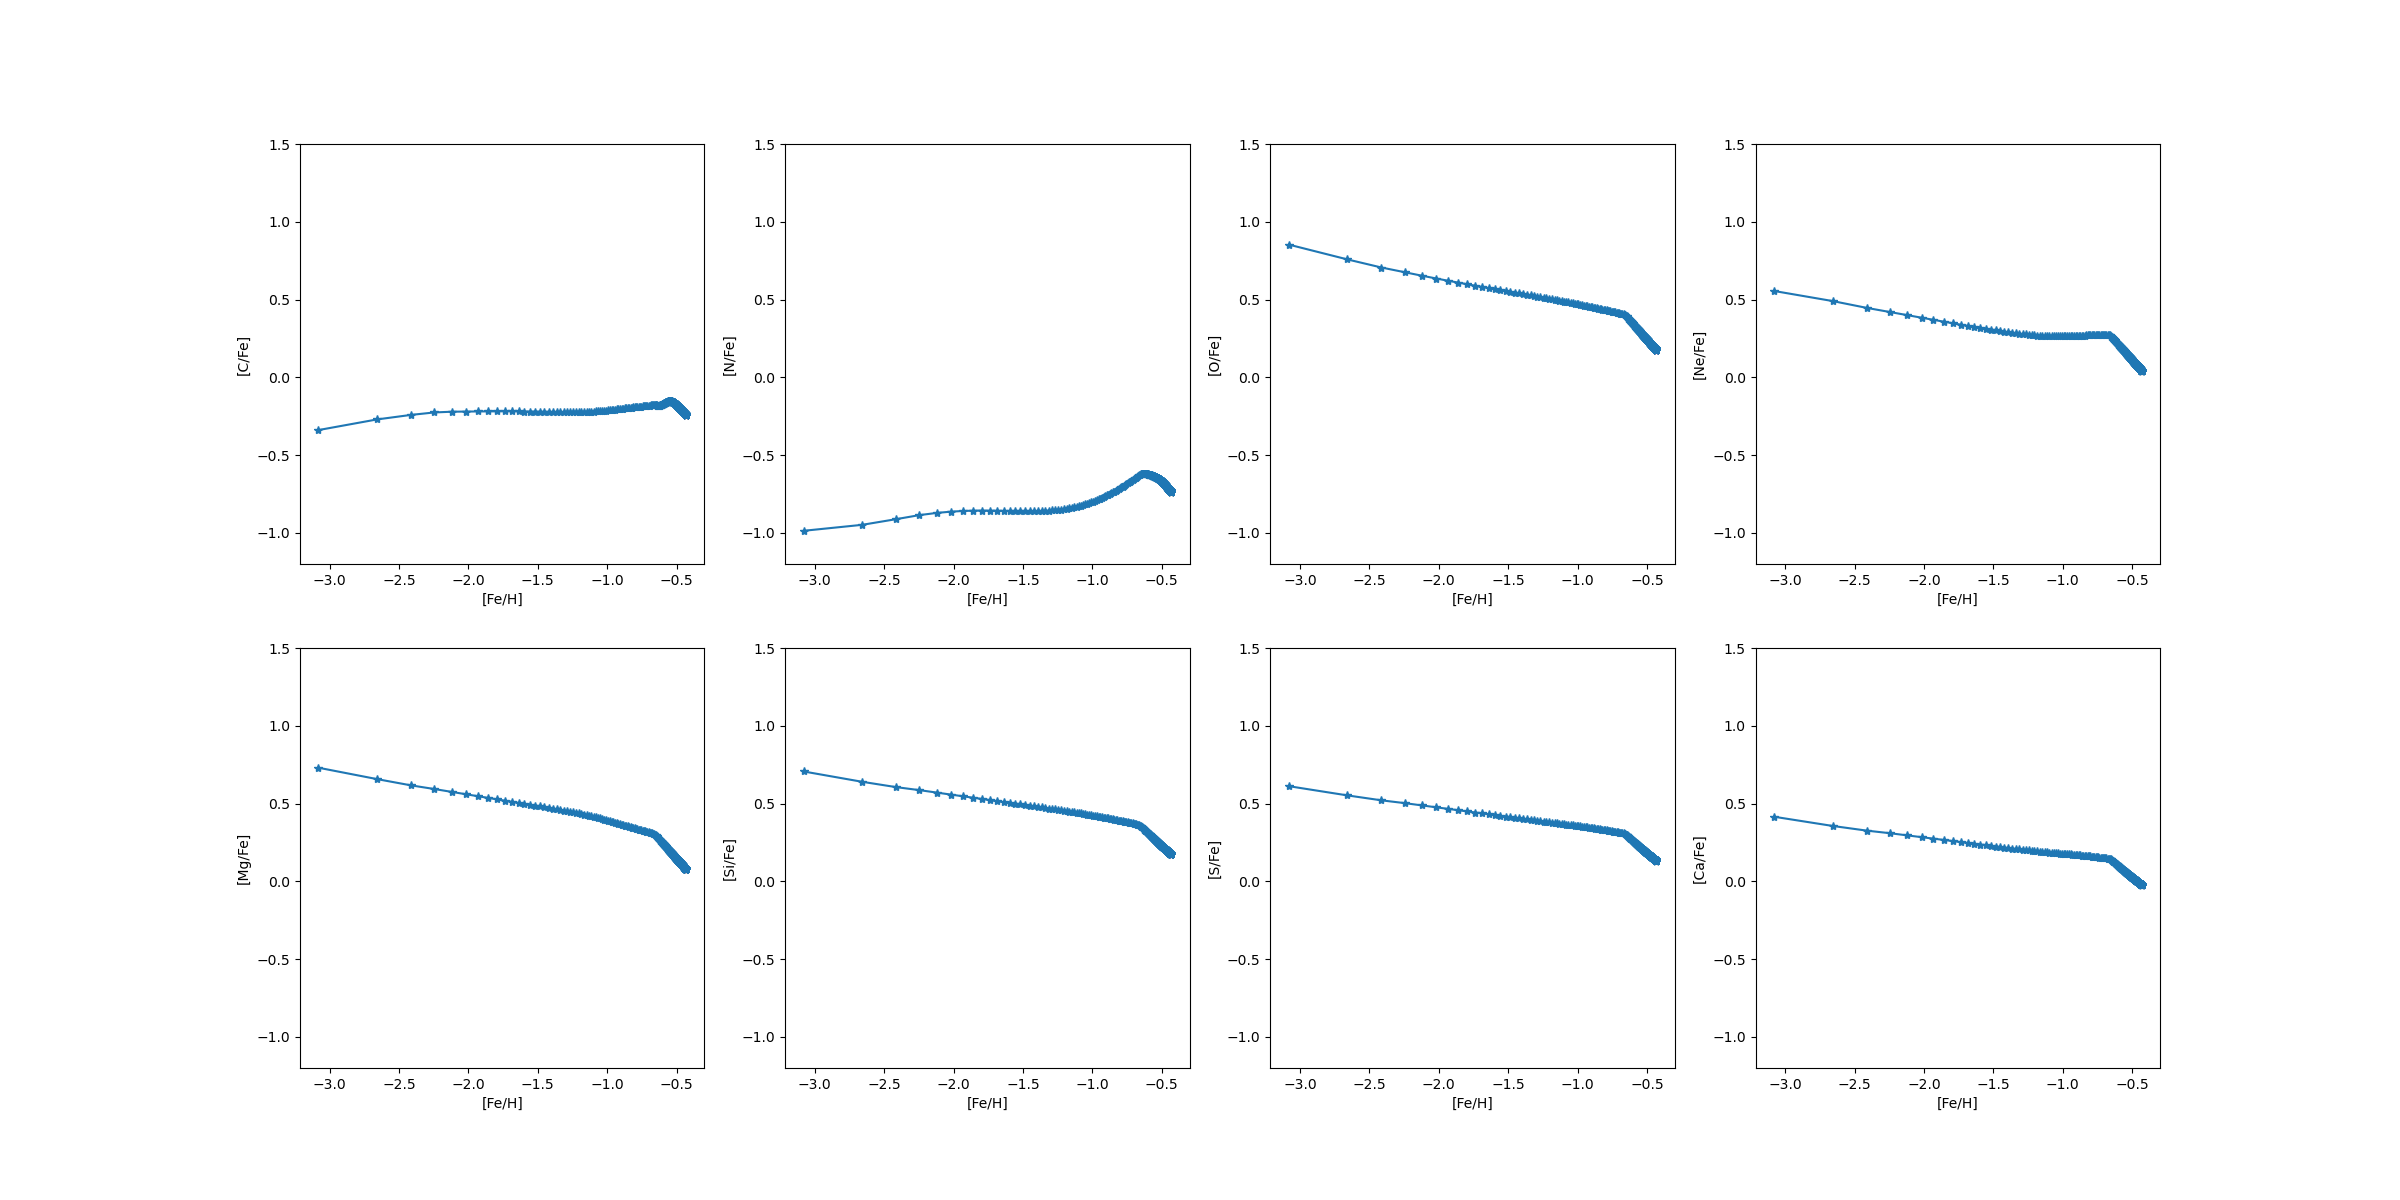

In [16]:
Zi2Zj = { }
Zi2Zj.update(GetZi2Zj(GasElement, "Fe", "H", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "C", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "N", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "O", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Ne", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Mg", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Si", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "S", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Ca", "Fe", solar_set, fill_value=None))
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(6*4, 6*2))
axes = axes.flatten()
Zi_list = ['C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca']

for elem in Zi_list:
    ax = axes[Zi_list.index(elem)]
    ax.plot(Zi2Zj["[Fe/H]"], Zi2Zj["[%s/Fe]"%elem], '-*')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[%s/Fe]'%elem)
    ax.set_ylim(-1.2, 1.5)

# fig.savefig("ChemEvoIMF_Zi2Zj-N13.pdf")
plt.show()

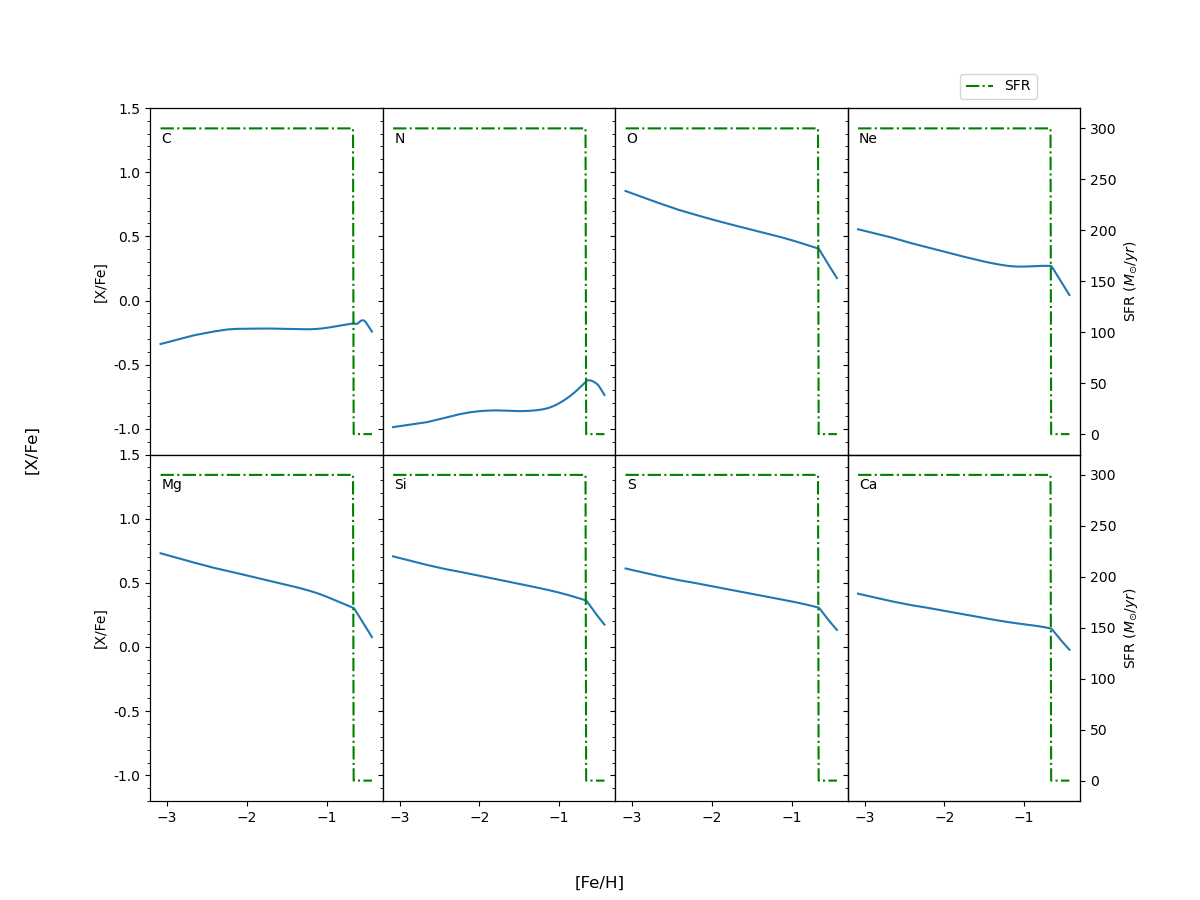

In [17]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(6*2, 4.5*2))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")

gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1], wspace=0, hspace=0)
axes = { }
axes['1'] = fig.add_subplot(gs[0])
axes['2'] = fig.add_subplot(gs[1])
axes['3'] = fig.add_subplot(gs[2])
axes['4'] = fig.add_subplot(gs[3])
axes['5'] = fig.add_subplot(gs[4])
axes['6'] = fig.add_subplot(gs[5])
axes['7'] = fig.add_subplot(gs[6])
axes['8'] = fig.add_subplot(gs[7])

Zi_list = ['C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca']

for i, elem in enumerate(Zi_list):
    ax = axes["%d"%(Zi_list.index(elem)+1)]
    ax.plot(Zi2Zj["[Fe/H]"], Zi2Zj["[%s/Fe]"%elem], '-')
    ax.annotate(elem, xy=(0.05, 0.9), xycoords='axes fraction')
    ax.set_ylim(-1.2, 1.5)
    minor_yticks = np.arange(-1.2, 1.5, 0.1)
    ax.set_yticklabels([])
    ax.set_yticks(minor_yticks, minor=True)
    ax1 = ax.twinx()
    ax1.set_ylim(-20,320)
    line1 = ax1.plot(Zi2Zj["[Fe/H]"], SFH['SFR'][Zi2Zj['Fe/H-mask']], 'g-.')
    ax1.set_yticks([])

major_yticks = np.arange(-1, 1.5+0.5, 0.5)
axes["1"].set_ylabel("[X/Fe]")
axes["1"].set_yticks(major_yticks)
axes["1"].set_yticklabels(major_yticks)
axes["5"].set_ylabel("[X/Fe]")
axes["5"].set_yticks(major_yticks)
axes["5"].set_yticklabels(major_yticks)
major_twin_yticks = np.arange(0, 300+50, 50)
ax1 = axes["4"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)
ax1 = axes["8"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)

fig.legend(line1, ['SFR'], loc=[0.8, 0.89])
fig.supxlabel('[Fe/H]')
fig.supylabel('[X/Fe]')
plt.show()

[]

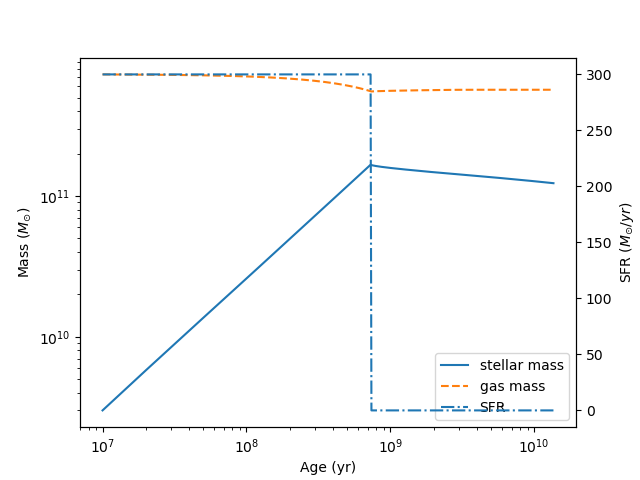

In [18]:
fig, ax = plt.subplots()
line1, = ax.plot(SFH['Age'], StellarMass, '-')
line2, = ax.plot(SFH['Age'], GasElement[:,1:31].sum(axis=1), '--')
ax.set_xlabel('Age (yr)')
ax.set_ylabel(r'Mass ($M_{\odot}$)')
ax1 = ax.twinx()
line3, = ax1.plot(SFH['Age'], SFH['SFR'], '-.')
ax1.set_ylabel(r'SFR ($M_{\odot}/yr$)')
ax.legend([line1, line2, line3], ['stellar mass', 'gas mass', 'SFR'])
ax.loglog()

Text(0, 0.5, 'Mass ($M_{\\odot}$)')

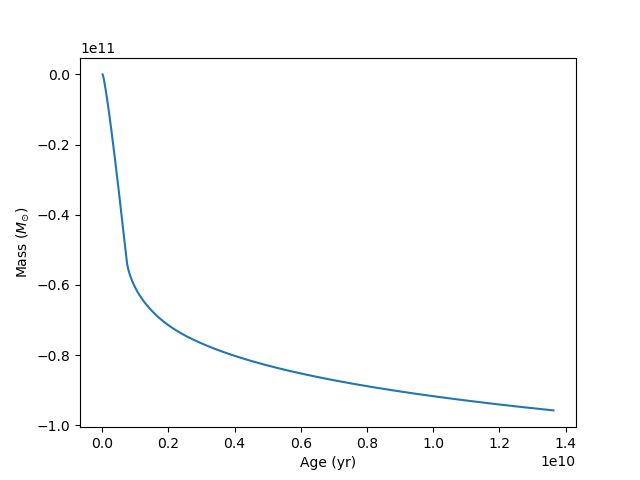

In [19]:
fig, ax = plt.subplots()
ax.plot(SFH['Age'], StellarMass - SFH['Mstar'].cumsum(), '-')
ax.set_xlabel('Age (yr)')
ax.set_ylabel(r'Mass ($M_{\odot}$)')